圧力一定境界（帯水層）にも対応

In [20]:
#import modules
import numpy as np
from scipy.sparse import spdiags, csr_matrix
from ResSimUtils_WellTest import cal_kro_WellTest, cal_krw_WellTest, cal_Ta_WellTest
from WellTest_analysis import cal_Pwf
from matplotlib import pyplot as plt
import warnings

<h2>結果の可視化＆保存用関数</h2>

In [21]:
# Pressure
def ShowResP_Cont(P, t, L, W, Pmin, Pmax, saveflag, showflag, fig):
    plt.imshow([P, P], extent = [0, L, 0, W], cmap = 'jet', vmin=Pmin, vmax=Pmax)
    plt.xlabel('L[m]')
    plt.ylabel('W[m]')
    plt.title("Reservoir Pressure [Pa]@ {:09.2f}days".format(t))
    plt.colorbar(aspect = 20, orientation= 'horizontal', shrink=1)
    if saveflag:
        plt.savefig('result_WellTest/ResP_Cont{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()
        
    plt.clf()
    return

def ShowResP_Plot(x, P, t, L, Pmin, Pmax, saveflag, showflag, fig):
  # Function to Plot & Save Pressure
  # fig = plt.figure()
    plt.plot(x, P, label='{0:09.2f}[day]'.format(t)) 
    plt.xlabel('x[m]')
    plt.ylabel('Water Saturation [-]')
    plt.xlim(0, L)
    plt.ylim(Pmin, Pmax)
    plt.grid()
    plt.title('Reservoir Pressure@{0:09.2f}[day]'.format(t))
    if saveflag:
        plt.savefig('result_WellTest/ResP_Plot{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()
    plt.clf()
    return

# Saturation
def ShowSw_Cont(Sw, t, L, W, saveflag, showflag, fig):
    plt.imshow([Sw, Sw], extent = [0, L, 0, W], cmap = 'jet', vmin=0, vmax=1)
    plt.xlabel('L[m]')
    plt.ylabel('W[m]')
    plt.title("Sw Profile@ {:09.2f}days".format(t))
    plt.colorbar(aspect = 20, orientation= 'horizontal', shrink=1)
    if saveflag:
        plt.savefig('result_WellTest/Sw_Cont{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()
    plt.clf()
    return

def ShowSw_Plot(x, Sw, t, L, saveflag, showflag, fig):
  # Function to Plot & Save Pressure
  # fig = plt.figure()
    plt.plot(x, Sw, label='{0:09.2f}[day]'.format(t)) 
    plt.xlabel('x[m]')
    plt.ylabel('Water Saturation [-]')
    plt.xlim(0, L)
    plt.ylim(0, 1)
    plt.grid()
    plt.title('Sw Profile@ {0:09.2f}[day]'.format(t))
    if saveflag:
        plt.savefig('result_WellTest/Sw_Plot{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()

    plt.clf()
    return

<h2>インプットパラメータ</h2>
必ず生産井がモデルの中央のブロックにあることを確認

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

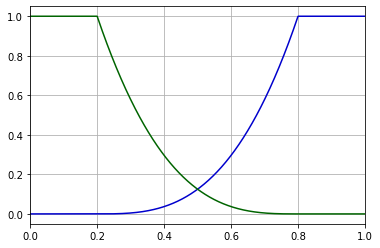

In [22]:
####### ----- Reservoir Properties and Simulation control ---- ######
# Simulation control Parameters
dt       = 1/24/6 # initial time step[day]. time step might be revised to meet CFL condition
t_max    = 30 #[day] simulation will continues until t becomes t_max
n_max    = 1e8 # maximum interation [-]
n_out    = 24*7 # 1000以上がいいと思う。0 means no output while simulation
Pmin     = 995 # Pressure lower limit for plot
Pmax     = 1000 # Pressure lower limit for plot
saveResP_contour = 0    # save png 
showResP_contour = 0    # show contour

saveResP_plot    = 0    # save png 
showResP_plot    = 0    # show plot

saveSw_contour   = 0    # save png
showSw_contour   = 0    # show contour

saveSw_plot      = 0    # save png 
showSw_plot      = 0    # show plot

fig1             = plt.figure(); # figure for pressure contour
fig2             = plt.figure(); # figure for pressure plot
fig3             = plt.figure(); # figure for saturation contour
fig4             = plt.figure(); # figure for saturation plot

# Reservoir Properties
Lx = 10000 # Reservoir Length in x direction [ft]
Ly = 1 # Reservoir Length in y direction [ft] # to avoid y-
h  = 20   # Reservoir tickness in z direction [ft]
nx = 31   # number of grid in x direction [-]
ny = 1   # number of grid in y direction [-]
dx = Lx / nx # grid size in x direction
dy = Ly / ny # grid size in y direction
perm_x  = 100*np.ones(nx) # Absolute permeability in x direction [mD]
# perm_y  = 100*np.ones(ny, nx) # Absolute permeability in y direction [mD]
phi_res = 0.3*np.ones(nx) # Porosity of reservoir [-]
P_init  = 3900*np.ones(nx) # Initial pressure in reservoir [PSI]

# define coordinate system
x    = np.zeros(nx)
x[0] = 0.5*dx
#y = np.np.zeros(ny)
#y[0] = 0.5*dy

# x coordinate
for i in range(1,len(x)):
    x[i] = x[i-1] + dx

###### ----- Fluid Properties ---- ######
# Injected water properties
vis_w        = 1.0 # viscosity of water [cp]
Bw           = 1.0 # formation volume factor of water
cw           = 1e-5 # compressibility of water [psi^-1]
Sw_i         = 0.2 # irreducible water saturation
Sw_init      = 0*np.ones(nx) # initial water saturation distribution
#Sw_init      = np.linspace(0, 1, nx)

perm_rw_max  = 1 # maximuam relative perm. of water [-]
nw           = 3.0 # exponent of water relative permeability curve [>1]

# Oil water Properties
vis_o        = 40.0 # viscosity of oil [cp]
Bo           = 1.1 # formation volume factor of oil
co           = 1e-5 # compressibility of oil [psi^-1]
So_r         = 0.2 # residual oil saturation
So_init      = 1 - Sw_init # initial oil saturation progile
perm_ro_max  = 1 # maximuam relative perm. of oil [-]
no           = 3.0 # exponent of oil relative permeability curve [>1]

###### ----- Boundary Condition (Aquifer) ---- ######
aquiferWest      = 0; # Aquifer exists at x = 0
aquiferEast      = 0; # Aquifer exists at x = Lx
perm_Aq_w        = 100;
perm_Aq_e        = 100;
perm_rw_Aq       = np.max(cal_krw_WellTest(np.zeros(2), Sw_i, So_r, perm_rw_max, nw));
perm_ro_Aq       = np.max(cal_kro_WellTest(np.ones(2), Sw_i, So_r, perm_rw_max, nw));
Pb_w             = 3900;
Pb_e             = 3900;

###### ----- Well, Production & Injection Information ---- ######
# Injection Well Properties
# injection wells are controlled by flow rate[ft^3 /day]. Injecters are
# composed of water flow rate. Producers are only controlled by total flow
# rate.

# Injection wells (source term)
#Qin = np.zeros(ny, nx) # Injection wells
Qin = np.zeros(nx) # Injection wells
#loc_Qin  = [16]
#Qin[loc_Qin[0]]   = 2*426.5

loc_Qin  = [0]
Qin[loc_Qin[0]]   = 0

# Production Well Properties
# production wells are controlled by flow rate[ft^s /day] or constant
# Bottom Hole Pressure, Pwf [PSI]. If Pwf is larger than Pi (mean pressure
# in CV), the situation is regarded as no production.

# Production wells (sink term) controlled by Flow Rate --------------------
#Qout = np.zeros(ny, nx) # Production wells
Qout = np.zeros(nx)
#Qout_loc  = [0, 29]
#Qout_name = ['P-1', 'P-2']
#Qout[Qout_loc[0]]   = -426.5
#Qout[Qout_loc[1]]   = -426.5

Qout_loc  = [int((nx-1)/2)]
Qout_name = ['P-1']
Qout[Qout_loc[0]]   = -701/10 # [res cu ft / day], 125[rbbl/day]


t_open  = 1 # after t_shut [day], all of production wells are openedf 0
t_shut  = 0 # after t_shut [day], all of production wells are shut down, if 0 , wells are not shut down

# Array to hold Production History
ProdOil   = np.zeros([len(Qout_loc)]) # numpy array to hold Production History of Oil
ProdWater = np.zeros([len(Qout_loc)]) # numpy array to hold Production History of Water
ProdResP  = np.zeros([len(Qout_loc)]) # numpy array to hold Pressure Change at reservoir block where Production wells are located
t_hist    = []

###### ----- Show Relative Permeability Curve ---- ######
Sw_sample = np.linspace(0, 1, 1000);
krw_sample = cal_krw_WellTest(Sw_sample, Sw_i, So_r, perm_rw_max, nw)
kro_sample = cal_kro_WellTest(Sw_sample, Sw_i, So_r, perm_ro_max, no)

fig_RelPerm = plt.figure();
ax_rp  = fig_RelPerm.add_subplot(1,1,1)
ax_rp.plot(Sw_sample, krw_sample, color='#0000cd', label= 'Rel. Perm. Water')
ax_rp.plot(Sw_sample, kro_sample, color='#006400', label= 'Rel. Perm. Oil')
ax_rp.set_xlim(0, 1)
ax_rp.set_ylim(-0.05, 1.05)
ax_rp.grid()
plt.show()

<h2>計算部分</h2>

In [23]:
# Initialize Pressure and Saturation
p_old  = P_init
Sw_old = Sw_init

# time step
t = 0; n = 0;

# Initial Production
perm_rw = cal_krw_WellTest(Sw_old, Sw_i, So_r, perm_rw_max, nw)
perm_ro = cal_kro_WellTest(Sw_old, Sw_i, So_r, perm_ro_max, no)
# calculate fractional flow
lam_w = perm_rw / vis_w # mobility of water
lam_o = perm_ro / vis_o # mobility of oil

fw    = lam_w / (lam_w + lam_o) # fractional flow of water
fo    = lam_o / (lam_w + lam_o) # fractional flow of oil

# Production History
t_hist.append(t)
if t_open == 0:
    ProdWater[:] = -fw[Qout_loc] * Qout[Qout_loc]
    ProdOil[:]   = -(Bw/Bo) * fo[Qout_loc] * Qout[Qout_loc]
    ProdResP[:]  = p_old[Qout_loc]
else:
    ProdWater[:] = 0
    ProdOil[:]   = 0
    ProdResP[:]  = p_old[Qout_loc]

# plot initial states
ShowResP_Cont(p_old, t, Lx, Ly, Pmin, Pmax, saveResP_contour, showResP_contour, fig1)
ShowResP_Plot(x, p_old, t, Lx, Pmin, Pmax, saveResP_plot, showResP_plot, fig2)
ShowSw_Cont(Sw_old, t, Lx, Ly, saveSw_contour, showSw_contour, fig3)
ShowSw_Plot(x, Sw_old, t, Lx, saveSw_plot, showSw_plot, fig4)


<Figure size 432x288 with 0 Axes>

In [24]:
len(t_hist)

1

In [25]:
np.size(ProdOil)

1

In [26]:
# define matrix B and d
CV_vol = h*dx*dy
B      = spdiags(CV_vol*phi_res*cw/Bw, 0, nx, nx) # Volume accumlation for Pressure Eq.
D      = spdiags(Bw/(CV_vol*phi_res), 0, nx, nx) # d for Saturation Eq.
Qout_cal = np.zeros(np.size(Qout))

# start simulation
print('Start Simulation')
print('{0:06d} th iteration, {1:09.2f} days'.format(n, t))
while True:
    #print('p_old', p_old[Qout_loc])
    if t_shut > 0:
        if t < t_open:
            Qout_cal[:] = 0
        elif t_open <= t < t_shut:
            Qout_cal[:] = Qout
        elif t_shut <= t:
            Qout_cal[:] = 0     

    else:
        if t >= t_open:
            Qout_cal[:] = Qout

    
    # compute Relative Permeability
    perm_rw = cal_krw_WellTest(Sw_old, Sw_i, So_r, perm_rw_max, nw)
    perm_ro = cal_kro_WellTest(Sw_old, Sw_i, So_r, perm_ro_max, no)
    
    # compute Transmissibility matrix
    T_water, bcs_w = cal_Ta_WellTest(perm_x,  perm_rw, h, dx, dy, vis_w, Bw, p_old, nx, \
                         aquiferWest, aquiferEast, Pb_w, Pb_e, perm_Aq_w, perm_Aq_e, perm_rw_Aq)
    T_oil, bcs_o   = cal_Ta_WellTest(perm_x,  perm_ro, h, dx, dy, vis_o, Bo, p_old, nx, \
                         aquiferWest, aquiferEast, Pb_w, Pb_e, perm_Aq_w, perm_Aq_e, perm_ro_Aq)
    
    # solve pressure Eq.
    p_new = np.linalg.solve((T_water + Bo/Bw*T_oil + (B.toarray()/dt)),\
                            (np.dot((B.toarray()/dt), p_old)+ Qin + Qout_cal + bcs_w + bcs_o))
    
    #print('p_new', p_new[Qout_loc])
    
    # calculate fractional flow
    lam_w = perm_rw / vis_w # mobility of water
    lam_o = perm_ro / vis_o # mobility of oil
    
    fw    = lam_w / (lam_w + lam_o) # fractional flow of water
    fo    = lam_o / (lam_w + lam_o) # fractional flow of oil
    
    # solve water-saturation Eq.
    Sw_new = Sw_old + (D*dt)*(np.dot(-T_water.toarray(),p_new) + Qin + fw*Qout_cal + bcs_w)
    
    # check convergence of saturation # it might be better choice to include this if-statement in the output-result if block
    if np.max(Sw_new) > 1.0:
        warnings.warn('The Maximum Value of Sw is bigger than 1.Stop Simulation')
        break
    
    # update time, pressure, saturation
    t += dt
    n += 1
    p_old  = p_new
    Sw_old = Sw_new
    
    # output result
    if n % n_out == 0:
        print('{0:06d} th iteration, {1:09.2f} days'.format(n, t))
        # Pressure and Saturation Profile
        ShowResP_Cont(p_old, t, Lx, Ly, Pmin, Pmax, saveResP_contour, showResP_contour, fig1)
        ShowResP_Plot(x, p_old, t, Lx, Pmin, Pmax, saveResP_plot, showResP_plot, fig2)
        ShowSw_Cont(Sw_old, t, Lx, Ly, saveSw_contour, showSw_contour, fig3)
        ShowSw_Plot(x, Sw_old, t, Lx, saveSw_plot, showSw_plot, fig4)
        
        # Production History
        t_hist.append(t)
        ProdWater = np.concatenate([ProdWater, -fw[Qout_loc] * Qout_cal[Qout_loc]], 0)
        ProdOil   = np.concatenate([ProdOil,   -(Bw/Bo) * fo[Qout_loc] * Qout_cal[Qout_loc]], 0)
        ProdResP  = np.concatenate([ProdResP, p_new[Qout_loc]], 0)
    
    
    # exit infinite loop
    if t >= t_max or n >= n_max:
        print('End Simulation')
        break
t_end = t

Start Simulation
000000 th iteration, 000000.00 days
000168 th iteration, 000001.17 days
000336 th iteration, 000002.33 days
000504 th iteration, 000003.50 days
000672 th iteration, 000004.67 days
000840 th iteration, 000005.83 days
001008 th iteration, 000007.00 days
001176 th iteration, 000008.17 days
001344 th iteration, 000009.33 days
001512 th iteration, 000010.50 days
001680 th iteration, 000011.67 days
001848 th iteration, 000012.83 days
002016 th iteration, 000014.00 days
002184 th iteration, 000015.17 days
002352 th iteration, 000016.33 days
002520 th iteration, 000017.50 days
002688 th iteration, 000018.67 days
002856 th iteration, 000019.83 days
003024 th iteration, 000021.00 days
003192 th iteration, 000022.17 days
003360 th iteration, 000023.33 days
003528 th iteration, 000024.50 days
003696 th iteration, 000025.67 days
003864 th iteration, 000026.83 days
004032 th iteration, 000028.00 days
004200 th iteration, 000029.17 days
End Simulation


<Figure size 432x288 with 0 Axes>

<h2>生産履歴, Pressure Saturarion Profile</h2>

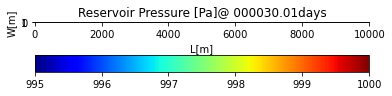

<Figure size 432x288 with 0 Axes>

In [27]:
ShowResP_Cont(p_old, t, Lx, Ly, Pmin, Pmax, saveResP_contour, 1, fig1)

-655.2307562122436
1095.338904428042


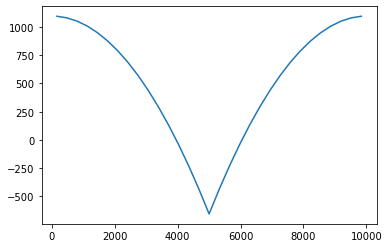

In [28]:
print(np.min(p_new))
print(np.max(p_new))
plt.plot(x, p_old)

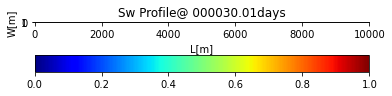

<Figure size 432x288 with 0 Axes>

In [29]:
ShowSw_Cont(Sw_old, t, Lx, Ly, saveSw_contour, 1, fig3)

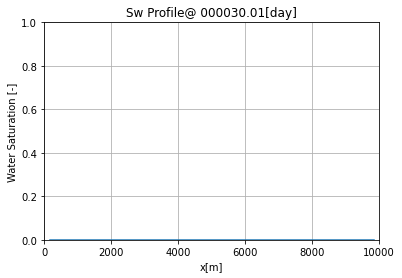

<Figure size 432x288 with 0 Axes>

In [30]:
ShowSw_Plot(x, Sw_old, t, Lx, 0, 1, fig4)

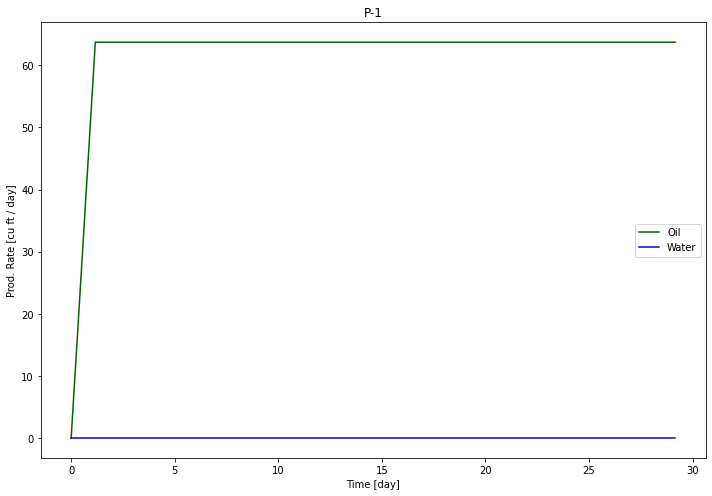

In [31]:
Oil = ProdOil.reshape(-1, len(Qout_loc))
Water = ProdWater.reshape(-1, len(Qout_loc))

fig_prod, ax = plt.subplots(len(Qout_loc), 1, tight_layout=True, figsize= (10, 7))

# default
ind_str = 0
ind_end = len(t_hist)

# cutomize
#ind_str = 170
#ind_end = 280

for i in range(0, len(Qout_loc)):
    if len(Qout_loc) == 1:
        #
        ax.plot(t_hist[ind_str : ind_end], Oil[ind_str : ind_end,i], color='#006400', label= 'Oil')
        ax.plot(t_hist[ind_str : ind_end], Water[ind_str : ind_end,i], color='#0000cd', label= 'Water')
        ax.set_xlabel('Time [day]')
        ax.set_ylabel('Prod. Rate [cu ft / day]')
        ax.set_title(Qout_name[i])
        ax.legend()
    else:
        ax[i].plot(t_hist[ind_str : ind_end], Oil[ind_str : ind_end,i], color='#006400', label= 'Oil')
        ax[i].plot(t_hist[ind_str : ind_end], Water[ind_str : ind_end,i], color='#0000cd', label= 'Water')
        ax[i].set_xlabel('Time [day]')
        ax[i].set_ylabel('Prod. Rate [cu ft / day]')
        ax[i].set_title(Qout_name[i])
        ax[i].legend()

plt.subplots_adjust(wspace=0.4, hspace=0.6)

<h2>坑井試験解析</h2>

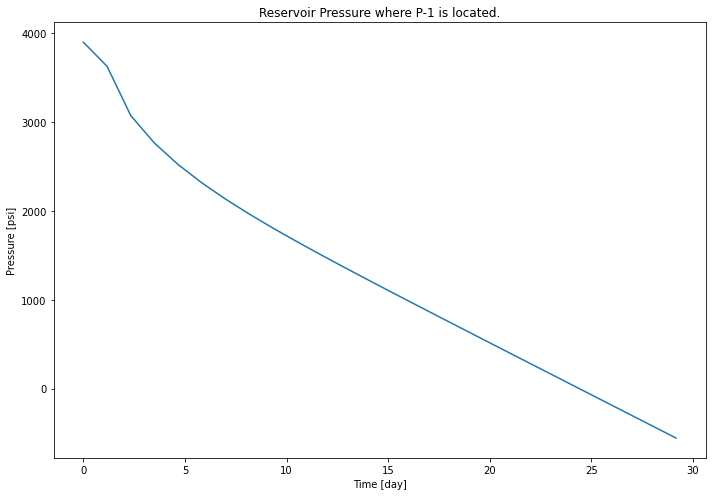

In [32]:
ResP_well = ProdResP.reshape(-1, len(Qout_loc))

fig_prod, ax = plt.subplots(len(Qout_loc), 1, tight_layout=True, figsize= (10, 7))

# default
ind_str = 0
ind_end = len(t_hist)

# cutomize
#ind_str = 170
#ind_end = 280

for i in range(0, len(Qout_loc)):
    if len(Qout_loc) == 1:
        ax.plot(t_hist[ind_str : ind_end], ResP_well[ind_str : ind_end,i])
        ax.set_xlabel('Time [day]')
        ax.set_ylabel('Pressure [psi]')
        ax.set_title('Reservoir Pressure where ' + Qout_name[i] + ' is located.')
    else:
        ax[i].plot(t_hist[ind_str : ind_end], ResP_well[ind_str : ind_end,i])
        ax[i].set_xlabel('Time [day]')
        ax[i].set_ylabel('Pressure [psi]')
        ax[i].set_title('Reservoir Pressure where ' + Qout_name[i] + ' is located.')

plt.subplots_adjust(wspace=0.4, hspace=0.6)

In [33]:
np.min(ResP_well)

-557.0413564621286

In [34]:
Pwf = cal_Pwf(Oil, ResP_well, perm_x[Qout_loc], perm_ro[Qout_loc], h, Bo, vis_o, 0.33, 100, dx)

In [35]:
print(np.size(ProdOil))
print(np.size(Oil))

26
26


In [36]:
np.size(ResP_well)

26

In [37]:
print(type(t_hist))
np.size(t_hist)

<class 'list'>


26

In [38]:
%matplotlib inline
t_hour = 24*np.array(t_hist)
tp_hour = t_hour - 24*t_open
print(np.size(tp_hour))
plt.plot(np.log10(tp_hour[np.min(np.where(tp_hour > 0)):np.max(np.where(tp_hour < 24*(t_shut-t_open)))]),\
                      Pwf[np.min(np.where(tp_hour > 0)):np.max(np.where(tp_hour < 24*(t_shut-t_open)))])
plt.show()

26


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
print(np.size(tp_hour))

Dt = tp_hour  - 24*t_shut
plt.plot(np.log10(tp_hour[np.min(np.where(tp_hour >= 24*(t_shut-t_open))):]),\
                      Pwf[np.min(np.where(tp_hour >= 24*(t_shut-t_open))):])
plt.show()

In [ ]:
Del_T = t_hour[np.min(np.where(tp_hour >= 24*t_shut)):]
tp = 24*t_shut - 24*t_open
Pws   = Pwf[np.min(np.where(tp_hour >= 24*t_shut)):] # BHP during shut in period

plt.plot(Del_T, Pws)

In [ ]:
XX=np.log10((tp+Del_T)/Del_T)
plt.plot(XX, Pws)